In [1]:
from pandas import Series, DataFrame
import statsmodels.api as sm
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline
from nltk.corpus import stopwords
from itertools import chain
from collections import Counter
import random
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Part A

### A1

In [2]:
train_data = pd.read_csv('Train_rev1.csv')

In [3]:
train_data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In order to find the top 5 POS, we need to first tokenize the full description.<br> 
We'll do this by first taking a random sample size of 2500.

In [4]:
random.seed(99)
sample_2500 = random.sample(range(len(train_data)),2500)
sample_data = train_data['FullDescription'][sample_2500]
sample_data[:3]

105900    Passionate about making lives better, Bupa is ...
99812     Category Manager  Milton Keynes High profile r...
52448     The Company: Our client enjoys a high profile ...
Name: FullDescription, dtype: object

Then we conduct nltk tokenize to our sample. But there's still some steps before tokenize.

In [5]:
full_des = sample_data.apply(lambda x:re.sub(r"[^a-z A-Z 0-9 \s]", "", x.lower())).sum()
des_words = nltk.word_tokenize(full_des)
des_words = [word for word in des_words if word.isalpha()==True] #get rid of punctuation

In [6]:
des_words

['passionate',
 'about',
 'making',
 'lives',
 'better',
 'bupa',
 'is',
 'dedicated',
 'to',
 'clinical',
 'excellence',
 'inspiring',
 'and',
 'supporting',
 'our',
 'nurses',
 'to',
 'put',
 'people',
 'at',
 'the',
 'heart',
 'of',
 'everything',
 'they',
 'do',
 'thats',
 'because',
 'with',
 'no',
 'shareholders',
 'to',
 'answer',
 'to',
 'were',
 'free',
 'to',
 'concentrate',
 'on',
 'the',
 'needs',
 'of',
 'our',
 'patients',
 'and',
 'so',
 'are',
 'you',
 'join',
 'us',
 'and',
 'you',
 'will',
 'be',
 'well',
 'looked',
 'after',
 'too',
 'with',
 'a',
 'great',
 'range',
 'of',
 'benefits',
 'and',
 'professional',
 'development',
 'to',
 'help',
 'you',
 'build',
 'the',
 'kind',
 'of',
 'nursing',
 'career',
 'youve',
 'always',
 'wanted',
 'what',
 'we',
 'expect',
 'from',
 'you',
 'you',
 'are',
 'a',
 'registered',
 'nurse',
 'with',
 'an',
 'or',
 'city',
 'and',
 'guilds',
 'qualification',
 'and',
 'valid',
 'nmc',
 'pin',
 'number',
 'you',
 'care',
 'about',
 

In [7]:
#This step takes a long time to run since the perceptor has to load everytime. 
pos = nltk.pos_tag(des_words)
pos[:10]

[('passionate', 'NN'),
 ('about', 'IN'),
 ('making', 'VBG'),
 ('lives', 'NNS'),
 ('better', 'JJR'),
 ('bupa', 'NN'),
 ('is', 'VBZ'),
 ('dedicated', 'VBN'),
 ('to', 'TO'),
 ('clinical', 'JJ')]

Then, get the top 5 POS.

In [8]:
cnt = Counter(tag for word,tag in pos)
cnt.most_common()[:5]

[('NN', 155735), ('JJ', 70263), ('IN', 65667), ('NNS', 51007), ('DT', 50898)]

Looks like 'NN': Singular Noun, 'JJ': Adjective, 'IN': Preposition or subordinating conjunction, 'NNS': Pural Noun and 'DT': Determiner are the 5 most common POS in the description.<br>
<br>
Let's do the process again and this time, exclude the stopwords.

In [9]:
#This step takes a *really* long time to run since the perceptor has to load everytime. 
filtered_stopwords = [word for word in des_words if word not in stopwords.words('english')]
filtered_pos = nltk.pos_tag(filtered_stopwords)
cnt2 = Counter(tag for word,tag in filtered_pos)
cnt2.most_common()[:5]

[('NN', 150579), ('JJ', 73248), ('NNS', 50538), ('VBG', 25538), ('VBP', 17299)]

After excluding the stopwords, Singular Noun, Adjective and Pural Noun are still in the top 5 list. Verb(gerund or present participle) and Verb(non-3rd person singular present) are added in the top 5 POS.

### A2

First, calculate the frequency of words and sort them.

In [10]:
#Calculate frequency.
fdist = nltk.FreqDist(des_words)

## Testing Zipf's law for top 100

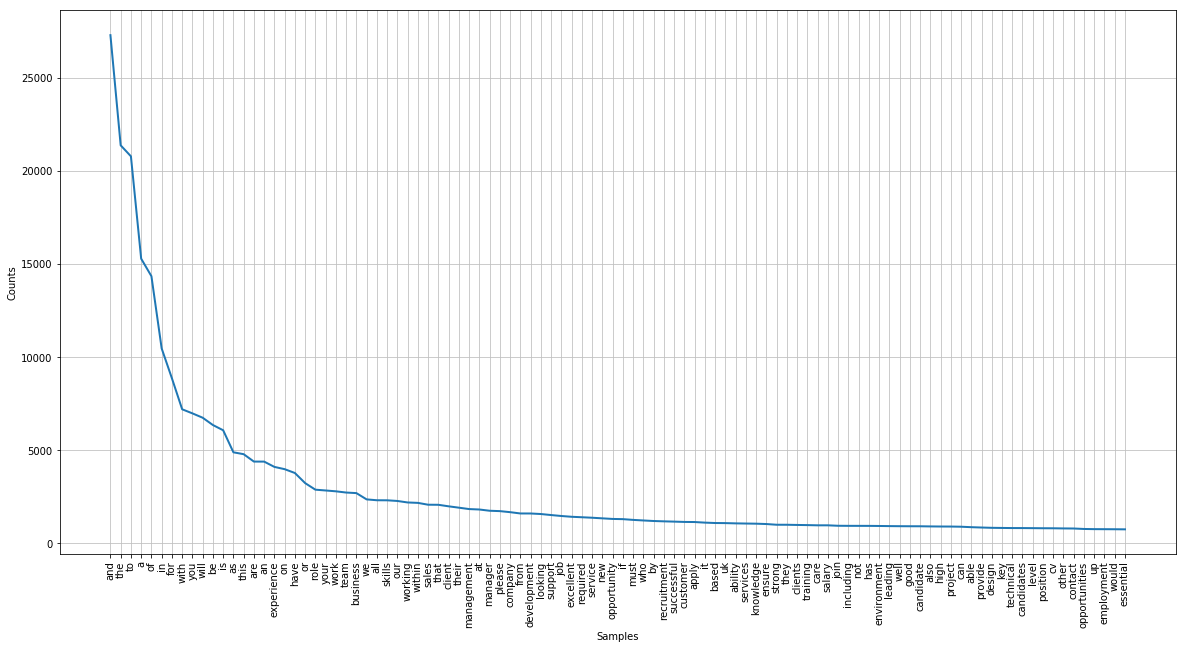

In [11]:
#Plot the top 100 against Zipf's Law
plt.figure(figsize=(20,10))
fdist.plot(100, cumulative=False)

In [12]:
#Sorted by frequency
sort_fdist = pd.DataFrame(sorted(fdist.items(), key=operator.itemgetter(1),reverse=True))
most_common_100 = sort_fdist[:100]
most_common_100.columns = ['word','frequency']
most_common_100['rank'] = most_common_100['frequency'].rank(method='min',ascending=False)
most_common_100['zipf_law'] = [most_common_100["frequency"].max()/r for r in most_common_100['rank']]
most_common_100[:10]

,word,frequency,rank,zipf_law
0,and,27307,1.0,27307.000000
1,the,21388,2.0,13653.500000
2,to,20798,3.0,9102.333333
3,a,15298,4.0,6826.750000
4,of,14357,5.0,5461.400000
5,in,10475,6.0,4551.166667
6,for,8871,7.0,3901.000000
7,with,7206,8.0,3413.375000
8,you,6987,9.0,3034.111111
9,will,6753,10.0,2730.700000


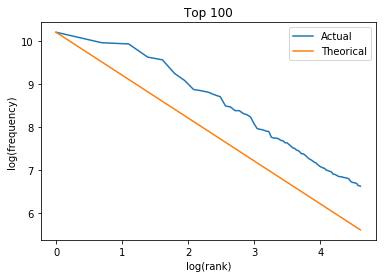

In [13]:
fig = plt.figure()

x = [math.log(c) for c in most_common_100['rank'].values]
y1 = [math.log(c) for c in most_common_100['frequency']]
y2 = [math.log(c) for c in most_common_100['zipf_law']]

ax1 = plt.plot(x,y1,label='Actual')
ax2 = plt.plot(x,y2,label='Theorical')

xlabel("log(rank)")
ylabel("log(frequency)")
title('Top 100')
plt.legend()
plt.show()

The above results show that the top 100 most does follow the Zipf's law in generally.<br>
Now, let's test the Zipf's law with the entire sample (2500 data points).

In [14]:
#from sklearn import datasets, linear_model
most_common_100['Y'] = [math.log(c) for c in most_common_100['frequency']]
x = most_common_100['frequency'] / (most_common_100['frequency'].max() * most_common_100.shape[0])
most_common_100['X'] = [math.log(c) for c in x]

In [15]:
y, X = dmatrices('Y ~ 0 + X', data=most_common_100, return_type='dataframe')

In [16]:
model = sm.OLS(y, X)       # Set up the model
#model = linear_model.LinearRegression()
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1849.
Date:                Thu, 13 Sep 2018   Prob (F-statistic):           7.37e-66
Time:                        01:06:04   Log-Likelihood:                -194.80
No. Observations:                 100   AIC:                             391.6
Df Residuals:                      99   BIC:                             394.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.9927      0.023    -42.996      0.0

We can see that the coeff is -0.9927, which is close to 1. Hence we can assume that the top 100 words in job description follow Zipf's law

## Testing Zipf's law for entire sample

In [17]:
sort_fdist.columns = ['word','frequency']
sort_fdist['rank'] = sort_fdist['frequency'].rank(method='min',ascending=False)
sort_fdist['zipf_law'] = [sort_fdist["frequency"].max()/r for r in sort_fdist['rank']]
sort_fdist.head()

,word,frequency,rank,zipf_law
0,and,27307,1.0,27307.000000
1,the,21388,2.0,13653.500000
2,to,20798,3.0,9102.333333
3,a,15298,4.0,6826.750000
4,of,14357,5.0,5461.400000


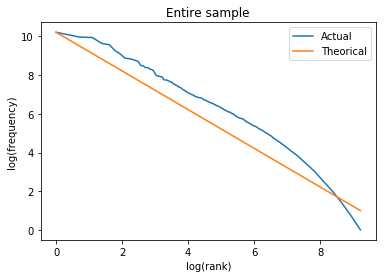

In [18]:
fig = plt.figure()

x = [math.log(c) for c in sort_fdist['rank'].values]
y1 = [math.log(c) for c in sort_fdist['frequency']]
y2 = [math.log(c) for c in sort_fdist['zipf_law']]

ax1 = plt.plot(x,y1,label='Actual')
ax2 = plt.plot(x,y2,label='Theorical')

xlabel("log(rank)")
ylabel("log(frequency)")
title('Entire sample')
plt.legend()
plt.show()

### Testing Zipf's law empirically

In [19]:
import statsmodels.api as sm
from patsy import dmatrices

In [20]:
#from sklearn import datasets, linear_model
sort_fdist['Y'] = [math.log(c) for c in sort_fdist['frequency']]
x = sort_fdist['frequency'] / (sort_fdist['frequency'].max() * sort_fdist.shape[0])
sort_fdist['X'] = [math.log(c) for c in x]

In [21]:
y, X = dmatrices('Y ~ 0 + X', data=sort_fdist, return_type='dataframe')

In [22]:
model = sm.OLS(y, X)       # Set up the model
#model = linear_model.LinearRegression()
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     7266.
Date:                Thu, 13 Sep 2018   Prob (F-statistic):               0.00
Time:                        01:06:10   Log-Likelihood:                -38628.
No. Observations:               20519   AIC:                         7.726e+04
Df Residuals:                   20518   BIC:                         7.727e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0494      0.001    -85.239      0.0

The coeff is negative, however closer to 0. Hence we can conclude that in the sample of 2500, the words occurring are not representative of any power law, in this case Zipf's law. This can be attributed to the fact that the words with lower ranks do not behave in this fashion. We will test for the same in the following pieces of code

## Testing Zipf's law for last 15000 words

In [23]:
y, X = dmatrices('Y ~ 0 + X', data=sort_fdist.tail(15000), return_type='dataframe')
model = sm.OLS(y, X)       # Set up the model
#model = linear_model.LinearRegression()
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     5088.
Date:                Thu, 13 Sep 2018   Prob (F-statistic):               0.00
Time:                        01:06:10   Log-Likelihood:                -10192.
No. Observations:               15000   AIC:                         2.039e+04
Df Residuals:                   14999   BIC:                         2.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0140      0.000    -71.334      0.0

We can clearly see here, that these words do not follow the power law

### A3

In [24]:
from nltk.corpus import wordnet
#create a function that would return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
         return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

In [25]:
wnl = WordNetLemmatizer()
#create an empty list to store lemmatized words
des_lem = []

In [26]:
def wn_pos(filtered_pos):
    for word,pos in filtered_pos:
        des_lem.append(wnl.lemmatize(word,get_wordnet_pos(pos)))
        #print pos
        #print get_wordnet_pos(pos)
    return des_lem

In [27]:
# Get the 10 most common words
fdist_2 = nltk.FreqDist(wn_pos(filtered_pos))
fdist_2.most_common(10)

[('work', 5196),
 ('experience', 4551),
 ('role', 3057),
 ('team', 3050),
 ('client', 2985),
 ('business', 2821),
 ('service', 2503),
 ('skill', 2290),
 ('within', 2178),
 ('sale', 2104)]

The top 10 most common words that appears in the job descriptions are shown above.

# PART B

### B1
#### Model with numeric columns only

In [28]:
#Reading training data
data = pd.read_csv('Train_rev1.csv')
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [29]:
data.dtypes

Id                     int64
Title                 object
FullDescription       object
LocationRaw           object
LocationNormalized    object
ContractType          object
ContractTime          object
Company               object
Category              object
SalaryRaw             object
SalaryNormalized       int64
SourceName            object
dtype: object

In [30]:
data_s = data[['LocationNormalized','ContractType','ContractTime','Category','SalaryNormalized']]
print(data_s.shape)
data_s.head()

(244768, 5)


,LocationNormalized,ContractType,ContractTime,Category,SalaryNormalized
0,Dorking,NaN,permanent,Engineering Jobs,25000
1,Glasgow,NaN,permanent,Engineering Jobs,30000
2,Hampshire,NaN,permanent,Engineering Jobs,30000
3,Surrey,NaN,permanent,Engineering Jobs,27500
4,Surrey,NaN,permanent,Engineering Jobs,25000


In [31]:
#Checking NA in Contract Type
data_s.ContractType.value_counts(dropna=False)

NaN          179326
full_time     57538
part_time      7904
Name: ContractType, dtype: int64

Since ~73% of ContractType is missing, we will not be using this column for our classification. Replacing NaN with "Full Time" will bias the data

In [32]:
data_s = data[['LocationNormalized','ContractTime','Category','SalaryNormalized']]
print(data_s.shape)
df = data_s.dropna()
df.shape

(244768, 4)


(180863, 4)

By dropping all rows with missing values, we lost about 65K rows (~26%). We will be using the clean dataset going forward

In [33]:
p=np.percentile(df['SalaryNormalized'],75)
def target(t):
    if t>p:
        return 1
    else:
        return 0
    
df['target'] = df['SalaryNormalized'].map(target)

#### Get a list of cities with highest cost of living.

In [34]:
#Get the top 10 highest CoL data from https://abcfinance.co.uk/blog/the-true-cost-of-living-in-uk-cities/
high_cost = ['London','Milton Keynes','Bath','Reading','Aberdeen','Cambridge','Oxford','Portsmouth','Edinburgh','York']

In [35]:
def location_class(s):
    if s in high_cost:
        return 'high'
    else:
        return 'low'
df['location_class'] = df['LocationNormalized'].map(location_class)

Now, get the dummies for each variables.

In [36]:
df.columns.values

array(['LocationNormalized', 'ContractTime', 'Category',
       'SalaryNormalized', 'target', 'location_class'], dtype=object)

In [37]:
categorical_columns = ['ContractTime', 'Category','location_class']
data_dummies = pd.get_dummies(df[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = data_dummies.columns.values
dummy_column_names

array(['ContractTime_contract', 'ContractTime_permanent',
       'Category_Accounting & Finance Jobs', 'Category_Admin Jobs',
       'Category_Charity & Voluntary Jobs', 'Category_Consultancy Jobs',
       'Category_Creative & Design Jobs',
       'Category_Customer Services Jobs',
       'Category_Domestic help & Cleaning Jobs',
       'Category_Energy, Oil & Gas Jobs', 'Category_Engineering Jobs',
       'Category_Graduate Jobs', 'Category_HR & Recruitment Jobs',
       'Category_Healthcare & Nursing Jobs',
       'Category_Hospitality & Catering Jobs', 'Category_IT Jobs',
       'Category_Legal Jobs', 'Category_Logistics & Warehouse Jobs',
       'Category_Maintenance Jobs', 'Category_Manufacturing Jobs',
       'Category_Other/General Jobs',
       'Category_PR, Advertising & Marketing Jobs',
       'Category_Part time Jobs', 'Category_Property Jobs',
       'Category_Retail Jobs', 'Category_Sales Jobs',
       'Category_Scientific & QA Jobs', 'Category_Social work Jobs',
       'C

In [38]:
df2 = pd.concat([df, data_dummies], axis=1)
df2.columns.values

array(['LocationNormalized', 'ContractTime', 'Category',
       'SalaryNormalized', 'target', 'location_class',
       'ContractTime_contract', 'ContractTime_permanent',
       'Category_Accounting & Finance Jobs', 'Category_Admin Jobs',
       'Category_Charity & Voluntary Jobs', 'Category_Consultancy Jobs',
       'Category_Creative & Design Jobs',
       'Category_Customer Services Jobs',
       'Category_Domestic help & Cleaning Jobs',
       'Category_Energy, Oil & Gas Jobs', 'Category_Engineering Jobs',
       'Category_Graduate Jobs', 'Category_HR & Recruitment Jobs',
       'Category_Healthcare & Nursing Jobs',
       'Category_Hospitality & Catering Jobs', 'Category_IT Jobs',
       'Category_Legal Jobs', 'Category_Logistics & Warehouse Jobs',
       'Category_Maintenance Jobs', 'Category_Manufacturing Jobs',
       'Category_Other/General Jobs',
       'Category_PR, Advertising & Marketing Jobs',
       'Category_Part time Jobs', 'Category_Property Jobs',
       'Category_Ret

Now, build Naive Bayes model.

Creating equation

In [39]:
formula = 'target ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))

In [40]:
Y, X = dmatrices(formula, df2, return_type='dataframe')
y = Y['target'].values

Since there is no validation dataset, we will create a testing/training sample here

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [42]:
from sklearn import naive_bayes
model = naive_bayes.BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [43]:
#Checking training accuracy
from sklearn import metrics
prediction_train = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction_train))

0.7600213789417424


The accuracy of using numerical variables are 76.06% on the training data

In [44]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction_train))

[[38624  2058]
 [10963  2614]]


#### Model with text columns only

Creating the dataset for classification

In [45]:
data.columns.values

array(['Id', 'Title', 'FullDescription', 'LocationRaw',
       'LocationNormalized', 'ContractType', 'ContractTime', 'Company',
       'Category', 'SalaryRaw', 'SalaryNormalized', 'SourceName'],
      dtype=object)

In [46]:
data_s = data[['FullDescription','SalaryNormalized']]

Creating target variable

In [47]:
p=np.percentile(data_s['SalaryNormalized'],75)
def target(t):
    if t>p:
        return 'high'
    else:
        return 'low'
    
data_s['target'] = data_s['SalaryNormalized'].map(target)

Taking a sample of 2500 rows

In [48]:
random.seed(99)
#sample = random.sample(range(len(data_s)),0.7 * len(data_s))
sample = random.sample(range(len(data_s)),2500)
df = data_s.loc[sample,:]
print(df.shape)

(2500, 3)


In [49]:
df.head()

,FullDescription,SalaryNormalized,target
105900,"Passionate about making lives better, Bupa is ...",24500,low
99812,Category Manager Milton Keynes High profile r...,50000,high
52448,The Company: Our client enjoys a high profile ...,27500,low
157139,PHP Web Developer A Leading digital agency ar...,14999,low
46871,"Due to continued growth, this new opportunity ...",42500,low


Cleaning the job description by:
1. Removing punctuation
2. Getting rid of stop words
3. Removing Numbers
4. Stripping excess whitespace

In [50]:
import re
from nltk.corpus import stopwords
#removing punctuation
df['job_des'] = df['FullDescription'].apply(lambda x:re.sub(r'[^a-zA-z\s]', ' ', x.lower()))

In [51]:
#remove white spaces
df['job_des'] = df.job_des.apply(lambda x:re.sub(r'\s+', ' ', x))

In [52]:
#remove stopwords
stop = set(stopwords.words('english'))
df['job_des_clean'] = df.job_des.apply(lambda x: [word for word in x.split() if word not in stop])
df.head()

,FullDescription,SalaryNormalized,target,job_des,job_des_clean
105900,"Passionate about making lives better, Bupa is ...",24500,low,passionate about making lives better bupa is d...,"[passionate, making, lives, better, bupa, dedi..."
99812,Category Manager Milton Keynes High profile r...,50000,high,category manager milton keynes high profile ro...,"[category, manager, milton, keynes, high, prof..."
52448,The Company: Our client enjoys a high profile ...,27500,low,the company our client enjoys a high profile i...,"[company, client, enjoys, high, profile, fasci..."
157139,PHP Web Developer A Leading digital agency ar...,14999,low,php web developer a leading digital agency are...,"[php, web, developer, leading, digital, agency..."
46871,"Due to continued growth, this new opportunity ...",42500,low,due to continued growth this new opportunity h...,"[due, continued, growth, new, opportunity, ari..."


Creating training data for Naive Bayes

Using just first 2000 words as features

In [53]:
job_des_all = df['job_des_clean'].sum()

In [54]:
all_words = nltk.FreqDist(job_des_all)
word_features = list(all_words)[:2000]
len(word_features)

2000

In [55]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [56]:
df2 = df[['target','job_des_clean']]
t = list(zip(df2.melt('target').value,df2.melt('job_des_clean').value))

In [57]:
featuresets = [(document_features(x[0]), x[1]) for x in t]

In [58]:
train_set, test_set = featuresets[2000:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [59]:
print(nltk.classify.accuracy(classifier, test_set))

0.796


In [60]:
classifier.show_most_informative_features(5)

Most Informative Features
         contains(risks) = True             high : low    =     13.9 : 1.0
    contains(definition) = True             high : low    =     13.9 : 1.0
  contains(demonstrated) = True             high : low    =      9.8 : 1.0
    contains(investment) = True             high : low    =      9.7 : 1.0
       contains(options) = True             high : low    =      8.8 : 1.0


## B2

In [61]:
import zipfile
import pandas as pd
import numpy as np
import nltk as nl
import os
pd.set_option('display.max_columns', None)


In [62]:
# dataset_name = 'job_salary'
# zf = zipfile.ZipFile('../data/'+dataset_name+ '.zip')
# files = zf.infolist()

# for f in files:
#     print("file present here is", f.filename)
#     df = pd.read_csv(zf.open(f.filename))

df = pd.read_csv('Train_rev1.csv')


In [63]:
df.shape

(244768, 12)

In [64]:
df_chosen = df.sample(2500, random_state=99)

In [65]:
col_names = ['location','contract_type','contract_time','type_of_job','salary']
num_data = df_chosen[['LocationNormalized','ContractType','ContractTime','Category','SalaryNormalized']]
num_data.columns = col_names 

In [66]:
p=np.percentile(num_data['salary'],75)
def target(t):
    if t>p:
        return 1
    else:
        return 0
    
num_data['target'] = num_data['salary'].map(target)

In [67]:
high_cost = ['London','Milton Keynes','Bath','Reading','Aberdeen','Cambridge','Oxford','Portsmouth','Edinburgh','York']
def location_class(s):
    if s in high_cost:
        return 1
    else:
        return 0
num_data['location_class'] = num_data['location'].map(location_class)

In [68]:
num_data.pop('location')
num_data.head()

,contract_type,contract_time,type_of_job,salary,target,location_class
143622,NaN,permanent,"PR, Advertising & Marketing Jobs",33000,0,0
161951,NaN,contract,IT Jobs,54000,1,0
58340,NaN,permanent,Graduate Jobs,17000,0,0
165857,part_time,NaN,Teaching Jobs,23040,0,0
107270,NaN,permanent,IT Jobs,31500,0,0


In [69]:
num_data[['contract_type', 'contract_time','type_of_job']].describe()

,contract_type,contract_time,type_of_job
count,652,1861,2500
unique,2,2,29
top,full_time,permanent,IT Jobs
freq,579,1552,375


### Since, many of the observations in 'contract_time', 'contract_type' are null, let's impute them using the most frequent value for  them

In [70]:
num_data['contract_time'] = num_data['contract_time'].fillna('permanent')
num_data['contract_type'] = num_data['contract_type'].fillna('full_time')
num_data[['contract_type', 'contract_time','type_of_job']].isnull().sum()

contract_type    0
contract_time    0
type_of_job      0
dtype: int64

In [71]:
df_model = num_data[['contract_type', 'contract_time', 'type_of_job','location_class','target']]
categorical_columns = ['contract_type', 'contract_time', 'type_of_job']
#num_data['contract_type'] = num_data['contract_time'].astype('category')
df_model = pd.get_dummies(df_model, columns= categorical_columns)

In [72]:
df_model.shape   ## Numerical data tranformed to dummy variables

(2500, 35)

In [73]:
df_model.head()

,location_class,target,contract_type_full_time,contract_type_part_time,contract_time_contract,contract_time_permanent,type_of_job_Accounting & Finance Jobs,type_of_job_Admin Jobs,type_of_job_Charity & Voluntary Jobs,type_of_job_Consultancy Jobs,type_of_job_Creative & Design Jobs,type_of_job_Customer Services Jobs,type_of_job_Domestic help & Cleaning Jobs,"type_of_job_Energy, Oil & Gas Jobs",type_of_job_Engineering Jobs,type_of_job_Graduate Jobs,type_of_job_HR & Recruitment Jobs,type_of_job_Healthcare & Nursing Jobs,type_of_job_Hospitality & Catering Jobs,type_of_job_IT Jobs,type_of_job_Legal Jobs,type_of_job_Logistics & Warehouse Jobs,type_of_job_Maintenance Jobs,type_of_job_Manufacturing Jobs,type_of_job_Other/General Jobs,"type_of_job_PR, Advertising & Marketing Jobs",type_of_job_Part time Jobs,type_of_job_Property Jobs,type_of_job_Retail Jobs,type_of_job_Sales Jobs,type_of_job_Scientific & QA Jobs,type_of_job_Social work Jobs,type_of_job_Teaching Jobs,type_of_job_Trade & Construction Jobs,type_of_job_Travel Jobs
143622,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
161951,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58340,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
165857,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
107270,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Now we include Text data, and make a boolean vector for the corpus' vocabulary
### Using a Bag o' Words approach to transform text to numerics

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = list(df_chosen['FullDescription'])
vectorizer = CountVectorizer()
corpus_bool = vectorizer.fit_transform(corpus).todense() 
corpus_bool[:10]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [75]:
corpus_bool.shape

(2500, 17985)

In [76]:
word_df = pd.DataFrame(vectorizer.fit_transform(corpus).todense(), columns= vectorizer.vocabulary_ )
dict_ = vectorizer.vocabulary_
dict_sorted = sorted(dict_ , key= lambda x: dict_[x], reverse=True) ## Sorting the dictionary based on frequency of words
dict_sorted = dict_sorted[:3000] ## Retaining only 3000 words
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
dict_filtrered = dictfilt(dict_, dict_sorted)

In [77]:
keys = list(dictfilt(dict_, dict_sorted).keys())
word_df = word_df[keys]

In [78]:
print(word_df.shape)
word_df.head()

(2500, 3000)


strategist  wnac  the  with  their  this  task  to  strategy  who  \
0           0     0    0     0      0     0     0   0         0    0   
1           0     0    0     0      0     0     0   0         0    0   
2           0     0    0     0      0     0     0   0         0    0   
3           0     0    0     0      0     0     0   0         0    0   
4           0     0    0     0      0     0     0   0         0    0   

   stepping  stone  strong  value  success  successful  will  work  well  \
0         0      0       0      0        0           0     0     0     0   
1         0      0       0      0        0           0     0     0     0   
2         0      0       0      0        0           0     0     0     0   
3         0      0       0      0        0           0     0     0     0   
4         0      0       0      0        0           0     0     0     0   

   team  your  working  you  today  step  towards  want  thank  uk  that  \
0     0     0        0    0      0     0        0     0      0   0     0   
1     0     0        0    0      0     0        0     0      0   0     0   
2     0     0        0    0      0     0        0     0      0   0     0   
3     0     0        0    0      0     1        0     0      0   0     0   
4     0     0        0    0      0     1        0     0      0   0     0   

   treated  strictest  without  we  whose  vacancies  visit  website  www  \
0        0          0        0   0      0          0      0        0    0   
1        0          0        0   0      0          0      0        0    0   
2        0          0        0   0      0          0      0        0    0   
3        0          0        0   0      0          0      0        0    0   
4        0          0        0   0      0          0      0        0    0   

   systems  solid  windows  switches  would  volumes  they  weekly  time  \
0        0      0        0         0      0        0     0       0     0   
1        0      0        0         0      0        0     0       0     0   
2        0      0        0         0      0        0     0       0     0   
3        0      0        0         0      0        0     0       0     0   
4        0      0        0         0      0        0     0       0     0   

   starters  telephone  tax  student  timesheets  ssp  word  under  vacancy  \
0         0          0    0        0           0    0     0      0        0   
1         0          0    0        0           0    0     0      0        0   
2         0          0    0        0           0    0     0      0        0   
3         0          0    0        0           0    0     0      0        0   
4         0          0    0        0           0    0     0      0        0   

   was  totaljobs  title  stl  supporting  teaching  staff  tutors  trainers  \
0    0          0      0    0           0         0      0       0         0   
1    0          0      0    0           0         0      0       0         0   
2    0          0      0    0           0         0      0       0         0   
3    0          0      0    0           0         0      0       0         0   
4    0          0      0    0           0         0      0       0         0   

   stating  which  subjects  undertaken  workers  software  world  specialist  \
0        0      0         0           0        0         0      0           0   
1        0      0         0           0        0         0      0           0   
2        0      0         0           0        0         0      0           0   
3        0      0         0           0        0         0      0           0   
4        0      0         0           0        0         0      0           0   

   wide  take  using  sql  visual  studio  xhtml  xml  technologies  \
0     0     0      0    0       0       0      0    0             0   
1     0     0      0    0       0       0      0    0             0   
2     0     0      0    0       0       0      0    2             0   
3     0  

In [79]:
df_model.rename(columns={'target':'my_response_variable'}, inplace=True)
df_model = df_model.reset_index(drop=True)
word_df= word_df.reset_index(drop=True)

In [80]:
full_data = df_model.join(word_df)
full_data.shape

(2500, 3035)

## Running Classification Task

In [81]:
Y_target = full_data['my_response_variable']
full_data.drop('my_response_variable', inplace=True, axis=1)


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(full_data, Y_target, test_size=500, random_state=42)

In [83]:
## User Defined Function for model training
def fit_the_model(X_train, y_train, model_name):
    if(model_name == 'NB'):
        clf = BernoulliNB()
        clf.fit(X_train, y_train)
        print(" Model fitting done by Naive Bayes Bernoulli")
        
    elif(model_name == 'RF'):
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        print("Model fitting done by Random Forest")
        
    return clf
## User Defined Function for model evaluation

def classification_model_evaluation(model, X_train, y_train, X_test, y_test):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    print ("Accuracy on Training data is", metrics.accuracy_score(y_train, prediction_train))
    print ("Accuracy on Test data is", metrics.accuracy_score(y_test, prediction_test))
    print('\n')
    print("Confusion Matrix FOR TEST Obtained is: \n ", confusion_matrix(y_test, prediction_test))
    print('\n')
    print("Confusion Matrix FOR TRAIN Obtained is: \n ", confusion_matrix(y_train, prediction_train))
    report = classification_report(y_test, prediction_test)
    print('\n')
    print("Classification Report \n", report)
    return ("Printed All the metrics for your classification model")

In [84]:
my_mod = fit_the_model(X_train, y_train, 'NB')
classification_model_evaluation(my_mod,X_train, y_train, X_test, y_test )

 Model fitting done by Naive Bayes Bernoulli
Accuracy on Training data is 0.846
Accuracy on Test data is 0.776


Confusion Matrix FOR TEST Obtained is: 
  [[339  41]
 [ 71  49]]


Confusion Matrix FOR TRAIN Obtained is: 
  [[1434   78]
 [ 230  258]]


Classification Report 
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       380
          1       0.54      0.41      0.47       120

avg / total       0.76      0.78      0.76       500



'Printed All the metrics for your classification model'

In [85]:
my_rf_mod = fit_the_model(X_train, y_train, 'RF')
classification_model_evaluation(my_rf_mod,X_train, y_train, X_test, y_test )

Model fitting done by Random Forest
Accuracy on Training data is 0.9735
Accuracy on Test data is 0.78


Confusion Matrix FOR TEST Obtained is: 
  [[375   5]
 [105  15]]


Confusion Matrix FOR TRAIN Obtained is: 
  [[1512    0]
 [  53  435]]


Classification Report 
              precision    recall  f1-score   support

          0       0.78      0.99      0.87       380
          1       0.75      0.12      0.21       120

avg / total       0.77      0.78      0.71       500



'Printed All the metrics for your classification model'

### It is evident that Naive Bayes performs better , as it doesn't result in overfittng, unlike Random Forest

In [86]:
import zipfile
import pandas as pd
import numpy as np
import nltk as nl
import os
pd.set_option('display.max_columns', None)


# dataset_name = 'job_salary'
# zf = zipfile.ZipFile('../data/'+dataset_name+ '.zip')
# files = zf.infolist()

# for f in files:
#     print("file present here is", f.filename)
#     df = pd.read_csv(zf.open(f.filename))

df = pd.read_csv('Train_rev1.csv')


df.shape

df_chosen = df.sample(2500, random_state=99)

col_names = ['location','contract_type','contract_time','type_of_job','salary']
num_data = df_chosen[['LocationNormalized','ContractType','ContractTime','Category','SalaryNormalized']]
num_data.columns = col_names 

p=np.percentile(num_data['salary'],75)
def target(t):
    if t>p:
        return 1
    else:
        return 0
    
num_data['target'] = num_data['salary'].map(target)

high_cost = ['London','Milton Keynes','Bath','Reading','Aberdeen','Cambridge','Oxford','Portsmouth','Edinburgh','York']
def location_class(s):
    if s in high_cost:
        return 1
    else:
        return 0
num_data['location_class'] = num_data['location'].map(location_class)

num_data.pop('location')
num_data.head()

num_data[['contract_type', 'contract_time','type_of_job']].describe()

### Since, many of the observations in 'contract_time', 'contract_type' are null, let's impute them using the most frequent value for  them

num_data['contract_time'] = num_data['contract_time'].fillna('permanent')
num_data['contract_type'] = num_data['contract_type'].fillna('full_time')
num_data[['contract_type', 'contract_time','type_of_job']].isnull().sum()

df_model = num_data[['contract_type', 'contract_time', 'type_of_job','location_class','target']]
categorical_columns = ['contract_type', 'contract_time', 'type_of_job']
#num_data['contract_type'] = num_data['contract_time'].astype('category')
df_model = pd.get_dummies(df_model, columns= categorical_columns)

df_model.shape   ## Numerical data tranformed to dummy variables

df_model.head()

### Now we include Text data, and make a boolean vector for the corpus' vocabulary
### Using a Bag o' Words approach to transform text to numerics

from sklearn.feature_extraction.text import CountVectorizer
corpus = list(df_chosen['FullDescription'])
vectorizer = CountVectorizer()
corpus_bool = vectorizer.fit_transform(corpus).todense() 
corpus_bool[:10]

corpus_bool.shape

word_df = pd.DataFrame(vectorizer.fit_transform(corpus).todense(), columns= vectorizer.vocabulary_ )
dict_ = vectorizer.vocabulary_
dict_sorted = sorted(dict_ , key= lambda x: dict_[x], reverse=True) ## Sorting the dictionary based on frequency of words
dict_sorted = dict_sorted[:3000] ## Retaining only 3000 words
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
dict_filtrered = dictfilt(dict_, dict_sorted)

keys = list(dictfilt(dict_, dict_sorted).keys())
word_df = word_df[keys]

print(word_df.shape)
word_df.head()

df_model.rename(columns={'target':'my_response_variable'}, inplace=True)
df_model = df_model.reset_index(drop=True)
word_df= word_df.reset_index(drop=True)

full_data = df_model.join(word_df)
full_data.shape

## Running Classification Task

Y_target = full_data['my_response_variable']
full_data.drop('my_response_variable', inplace=True, axis=1)


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(full_data, Y_target, test_size=500, random_state=42)

## User Defined Function for model training
def fit_the_model(X_train, y_train, model_name):
    if(model_name == 'NB'):
        clf = BernoulliNB()
        clf.fit(X_train, y_train)
        print(" Model fitting done by Naive Bayes Bernoulli")
        
    elif(model_name == 'RF'):
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        print("Model fitting done by Random Forest")
        
    return clf
## User Defined Function for model evaluation

def classification_model_evaluation(model, X_train, y_train, X_test, y_test):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    print ("Accuracy on Training data is", metrics.accuracy_score(y_train, prediction_train))
    print ("Accuracy on Test data is", metrics.accuracy_score(y_test, prediction_test))
    print('\n')
    print("Confusion Matrix FOR TEST Obtained is: \n ", confusion_matrix(y_test, prediction_test))
    print('\n')
    print("Confusion Matrix FOR TRAIN Obtained is: \n ", confusion_matrix(y_train, prediction_train))
    report = classification_report(y_test, prediction_test)
    print('\n')
    print("Classification Report \n", report)
    return ("Printed All the metrics for your classification model")

my_mod = fit_the_model(X_train, y_train, 'NB')
classification_model_evaluation(my_mod,X_train, y_train, X_test, y_test )

my_rf_mod = fit_the_model(X_train, y_train, 'RF')
classification_model_evaluation(my_rf_mod,X_train, y_train, X_test, y_test )

### It is evident that Naive Bayes performs better , as it doesn't result in overfittng, unlike Random Forest

(2500, 3000)
 Model fitting done by Naive Bayes Bernoulli
Accuracy on Training data is 0.846
Accuracy on Test data is 0.776


Confusion Matrix FOR TEST Obtained is: 
  [[339  41]
 [ 71  49]]


Confusion Matrix FOR TRAIN Obtained is: 
  [[1434   78]
 [ 230  258]]


Classification Report 
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       380
          1       0.54      0.41      0.47       120

avg / total       0.76      0.78      0.76       500

Model fitting done by Random Forest
Accuracy on Training data is 0.972
Accuracy on Test data is 0.764


Confusion Matrix FOR TEST Obtained is: 
  [[370  10]
 [108  12]]


Confusion Matrix FOR TRAIN Obtained is: 
  [[1512    0]
 [  56  432]]


Classification Report 
              precision    recall  f1-score   support

          0       0.77      0.97      0.86       380
          1       0.55      0.10      0.17       120

avg / total       0.72      0.76      0.70       500



'Printed All the metrics for your classification model'